### First, we'll carry out the forecast without removing what we consider to be outliers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sn.color_palette()
plt.style.use('fivethirtyeight')

In [23]:
df = pd.read_csv("C:\\Users\\USER\\Desktop\\New data\\PJME_hourly.csv")
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [24]:
df = df.set_index('Datetime')

In [21]:
color_pal 

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

<AxesSubplot:title={'center':'PJME energy use in MegaWatts'}, xlabel='Datetime'>

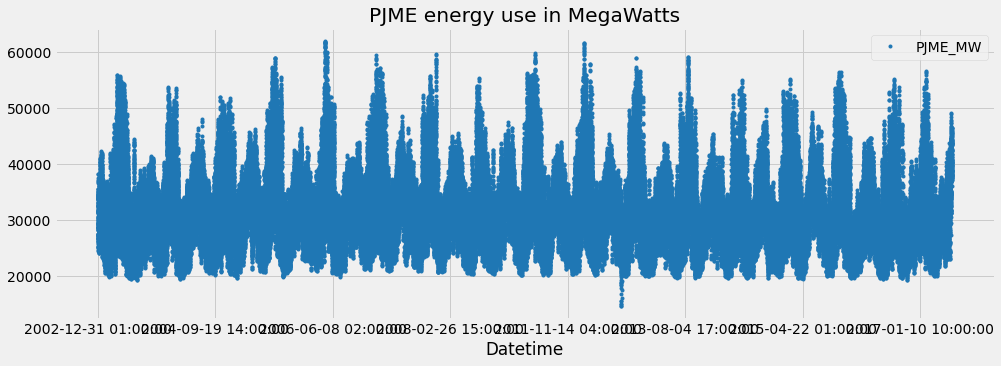

In [25]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJME energy use in MegaWatts')

In [26]:
df.index #DAtetime is an object and needs to be converted to datetime

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [27]:
df.index = pd.to_datetime(df.index) #conversion of datetime object to datetime


<AxesSubplot:title={'center':'PJME energy use in MegaWatts'}, xlabel='Datetime'>

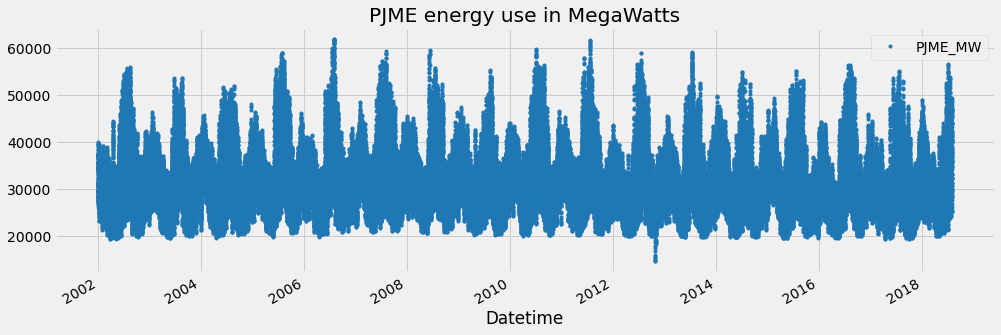

In [28]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJME energy use in MegaWatts')

Train Test Split

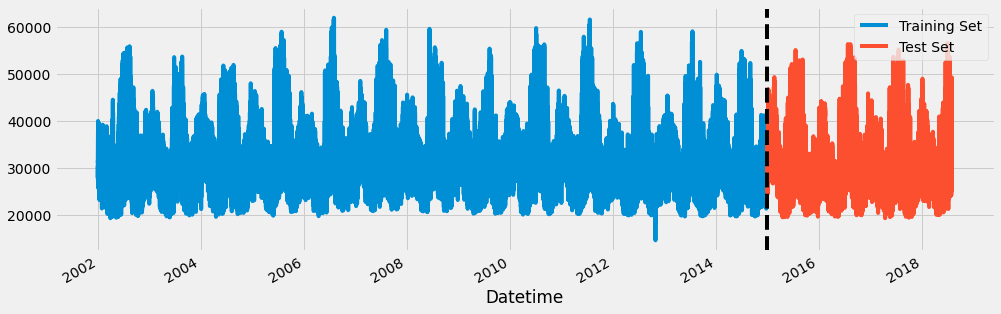

In [29]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label= 'Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color = 'black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

let's extract a week of data and see

<AxesSubplot:title={'center':'Week of Data'}, xlabel='Datetime'>

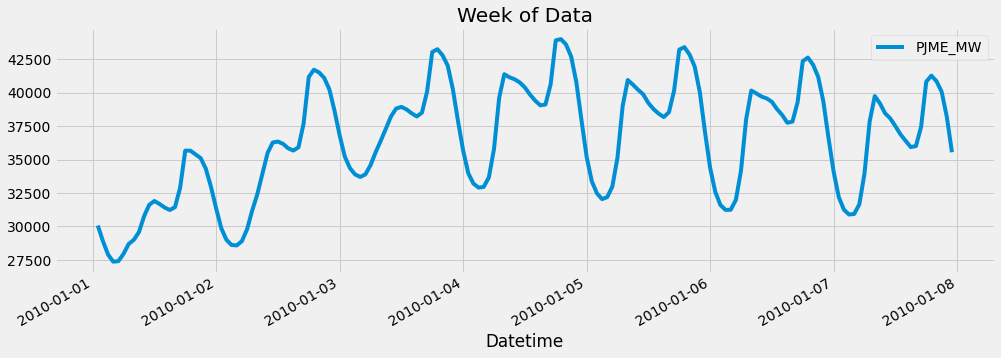

In [30]:
df.loc[(df.index > '01-01-2010')& (df.index < '01-08-2010')].plot(figsize=(15,5), title= 'Week of Data')

<AxesSubplot:title={'center':'Week of Data'}, xlabel='Datetime'>

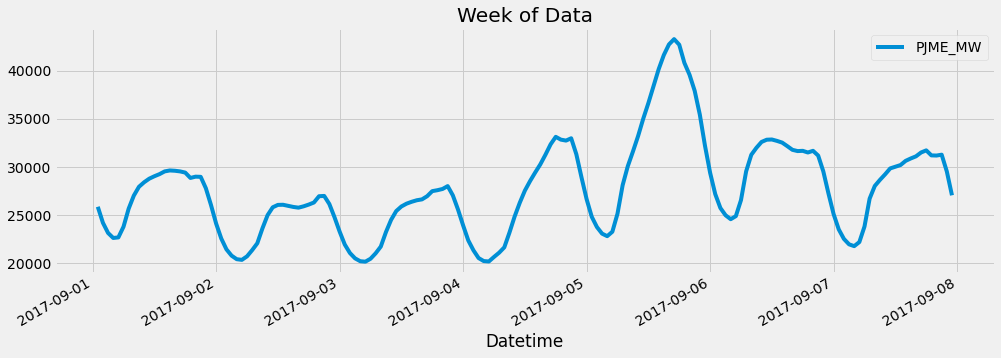

In [31]:
df.loc[(df.index > '09-01-2017')& (df.index < '09-08-2017')].plot(figsize=(15,5), title= 'Week of Data')

Feature Creation

In [32]:
    df['Hour'] = df.index.hour 
    df['dayofweek']= df.index.dayofweek
    df['Quarter']= df.index.quarter
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Dayofyear'] =  df.index.dayofyear

In [33]:
def create_features(df):    #Create time series features based on time series index
    df=df.copy()   #This ensures that we're editing a copy of the dataframe
    df['Hour'] = df.index.hour 
    df['dayofweek']= df.index.dayofweek
    df['Quarter']= df.index.quarter
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Dayofyear'] =  df.index.dayofyear
    return df

Text(0.5, 1.0, 'Megawatts by Hour')

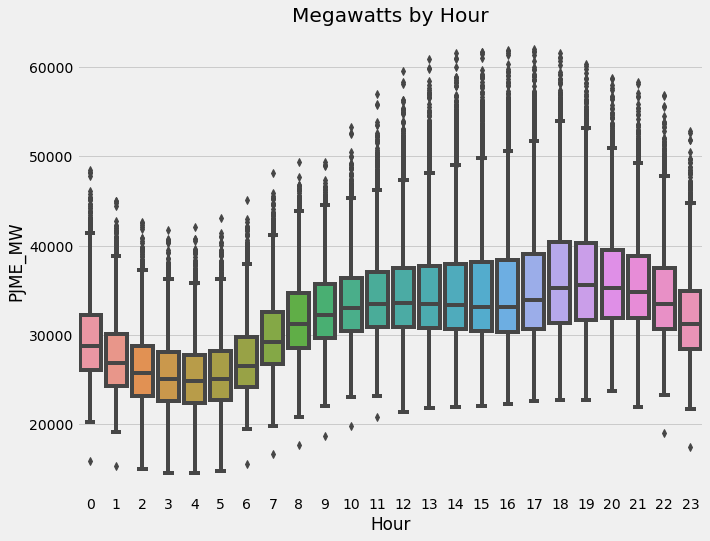

In [34]:
fig, ax = plt.subplots(figsize=(10,8))
sn.boxplot(data=df, x='Hour', y='PJME_MW')
ax.set_title('Megawatts by Hour')

#From the plot below, we can see that the energy consumption dips at midnigght and begins to increase till it peaks around 2-4PM and then begins to decrease again.

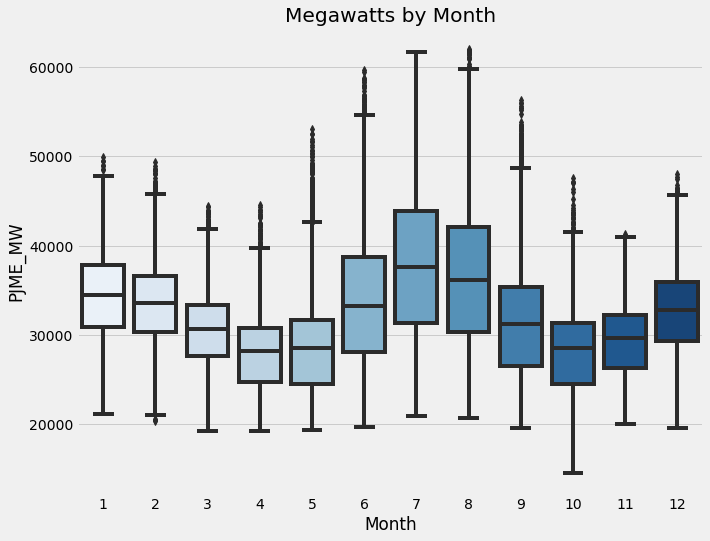

In [35]:
fig, ax = plt.subplots(figsize=(10,8))
sn.boxplot(data=df, x='Month', y='PJME_MW', palette='Blues')
ax.set_title('Megawatts by Month')
plt.show()

#From the plot below, we can see that the energy consumption dips at March and November and then peaks between June and August where everyoe is using their ACs.

Creating our model

In [36]:
train = create_features(train)
test = create_features(test)

In [37]:
df.columns

Index(['PJME_MW', 'Hour', 'dayofweek', 'Quarter', 'Month', 'Year',
       'Dayofyear'],
      dtype='object')

In [38]:
features = ['Hour', 'dayofweek', 'Quarter', 'Month', 'Year',
       'Dayofyear']
target = 'PJME_MW'

In [39]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [40]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=50, learning_rate = 0.01)
reg.fit(X_train, y_train,
       eval_set =[(X_train, y_train), (X_test, y_test) ], verbose = 100 )
#Verbose being set to a number instead of true/false means it should print after every interval of the set number
#It stopped at 450 trees because the performance started getting worse, an indication of overfitting.

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[451]	validation_0-rmse:2771.05175	validation_1-rmse:3731.37067


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Feature Importance

In [41]:
reg.feature_importances_

array([0.44880438, 0.1586678 , 0.03331862, 0.22815645, 0.02263376,
       0.10841895], dtype=float32)

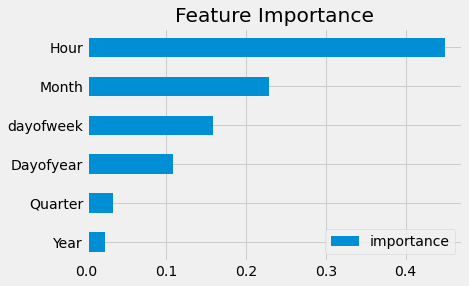

In [42]:
feat_imp = pd.DataFrame(data=reg.feature_importances_, index =  reg.feature_names_in_, columns = ['importance'])
feat_imp.sort_values('importance').plot(kind='barh', title = 'Feature Importance')
plt.show()

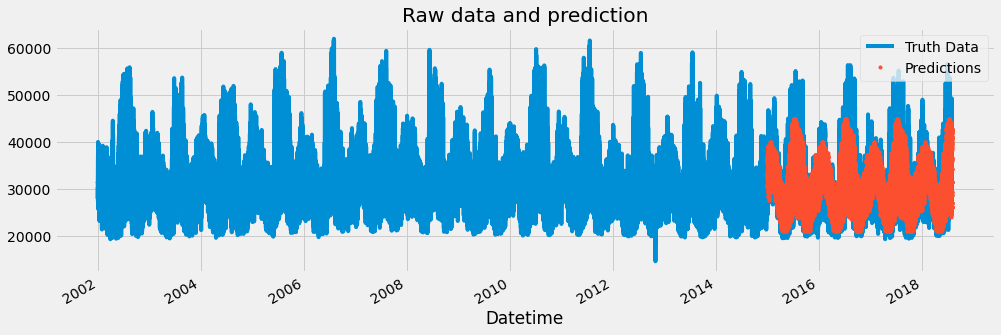

In [43]:
test['prediction'] = reg.predict(X_test)
df=df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style = '.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw data and prediction')
plt.show()

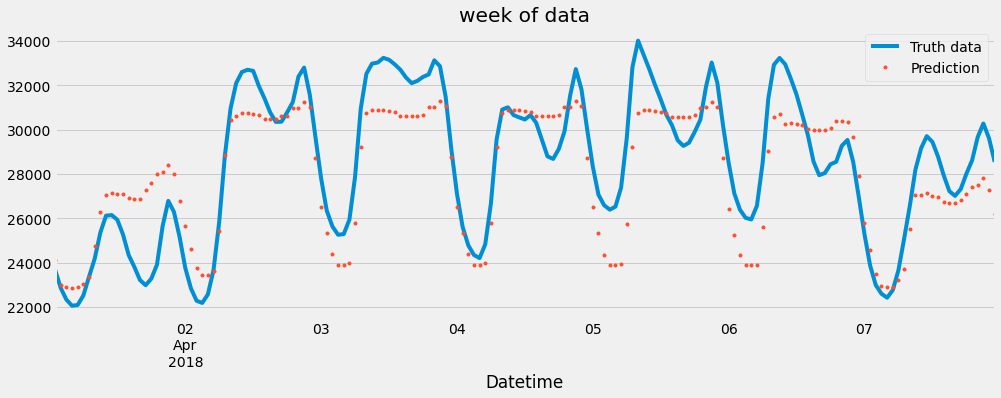

In [44]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
.plot(figsize = (15,5), title =  'week of data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
.plot(style='.')
plt.legend(['Truth data', 'Prediction'])
plt.show()


In [45]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f"RMSE Score on Test set: {score:0.2f}")

RMSE Score on Test set: 3715.93


# CALCULATE THE ERROR
- look at worst and best predicted days

In [46]:
test['error'] = np.abs(test[target] - test['prediction'])
test['date'] =  test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head
#From the result below, we can see that the worst predicted days are between 13th of August and September 2016 while 
#the best predicted days are randomly on April, May, September, December 2015 and March 2015.

<bound method NDFrame.head of date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
                  ...     
2016-12-08      494.141764
2016-05-01      465.372640
2015-03-10      456.506510
2016-09-27      396.752116
2016-04-04      389.607829
Name: error, Length: 1311, dtype: float64>

### Time Series forcasting without outliers

In [49]:
df_ = pd.read_csv("C:\\Users\\USER\\Desktop\\New data\\PJME_hourly.csv")
df_.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [50]:
df_ = df_.set_index('Datetime')

In [51]:
df_.index = pd.to_datetime(df_.index) #conversion of datetime object to datetime

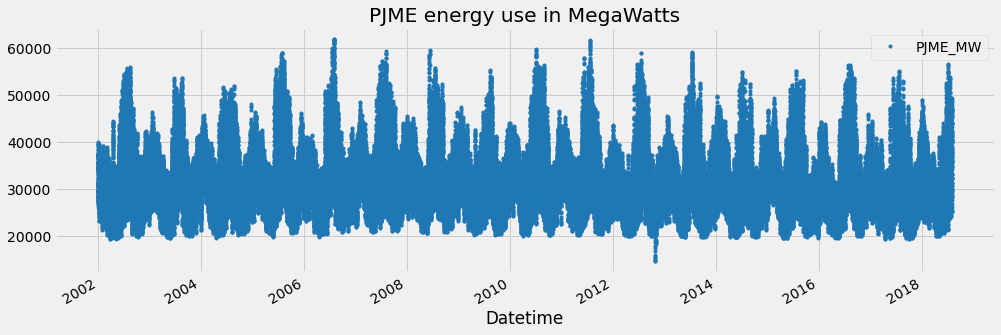

In [52]:
df_.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJME energy use in MegaWatts')
plt.show()

# Outlier Analysis and Removal

<AxesSubplot:ylabel='Frequency'>

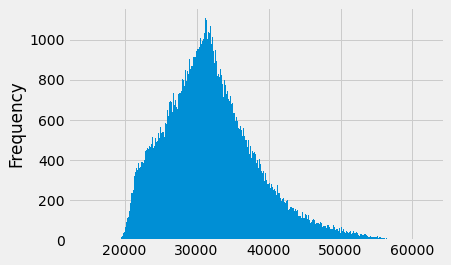

In [53]:
df_['PJME_MW'].plot(kind='hist', bins=500)

<AxesSubplot:xlabel='Datetime'>

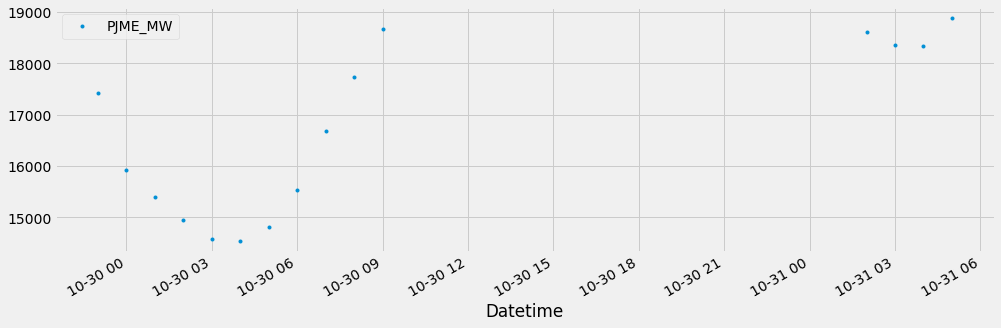

In [54]:
df_.query('PJME_MW < 19000').plot(figsize=(15,5), style = '.')
#Figures below 19000 are considered to be outliers.

In [55]:
df_.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [115]:
#df = df_.query('PJME_MW > 19000').copy()
#We

In [34]:
# q1 = np.percentile(df_['PJME_MW'], 25, interpolation = 'midpoint')
# q1


27573.0

In [35]:
# q3 = np.percentile(df_['PJME_MW'], 75, interpolation = 'midpoint')
# q3

35650.0

In [36]:
# iqr = q3-q1
# iqr

8077.0

In [37]:
# #Standard
# upper_bound = q3 + 1.5*iqr
# lower_bound = q1 - 1.5*iqr

In [38]:
# lower = df_['PJME_MW']<=(q1-1.5*iqr)
# #print('lower bound:', lower)
# print(np.where(lower))

(array([89114, 89115, 89116, 89117, 89118], dtype=int64),)


In [39]:
# upper = df_['PJME_MW']>=(q3 + 1.5*iqr)
# print('upper bound:', upper)

upper bound: Datetime
2002-12-31 01:00:00    False
2002-12-31 02:00:00    False
2002-12-31 03:00:00    False
2002-12-31 04:00:00    False
2002-12-31 05:00:00    False
                       ...  
2018-01-01 20:00:00    False
2018-01-01 21:00:00    False
2018-01-01 22:00:00    False
2018-01-01 23:00:00    False
2018-01-02 00:00:00    False
Name: PJME_MW, Length: 145366, dtype: bool


In [40]:
# dfx = df_.loc[~(df_['PJME_MW']>=(q3 + 1.5*iqr)) & (~(df_['PJME_MW']<=(q1-1.5*iqr)))].copy()
# dfx

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


<AxesSubplot:ylabel='Frequency'>

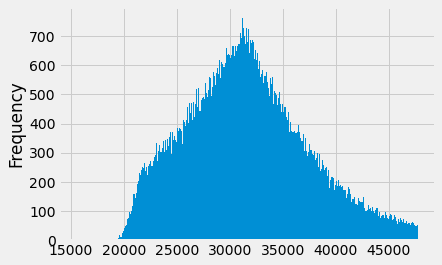

In [41]:
dfx['PJME_MW'].plot(kind='hist', bins=500)

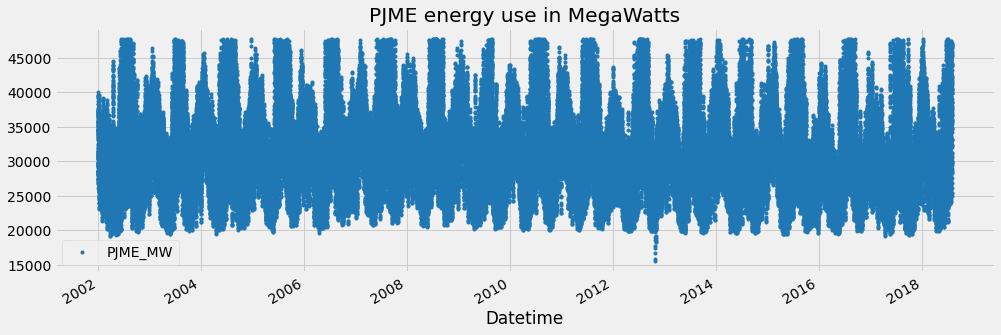

In [42]:
dfx.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJME energy use in MegaWatts')
plt.show()

In [43]:
# dfx.query('PJME_MW < 15457.5')

,PJME_MW
Datetime,


In [44]:
dfx.describe()

,PJME_MW
count,141911.000000
mean,31616.354243
std,5789.464103
min,15526.000000
25%,27461.000000
50%,31266.000000
75%,35248.000000
max,47765.000000


# Time series cross validation

In [56]:
from sklearn.model_selection import TimeSeriesSplit

In [76]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24 )
#gap is the number of samples to exclude from the end of each train set before the test set.
dfc = dfc.sort_index()

In [78]:
tss

TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=8760)

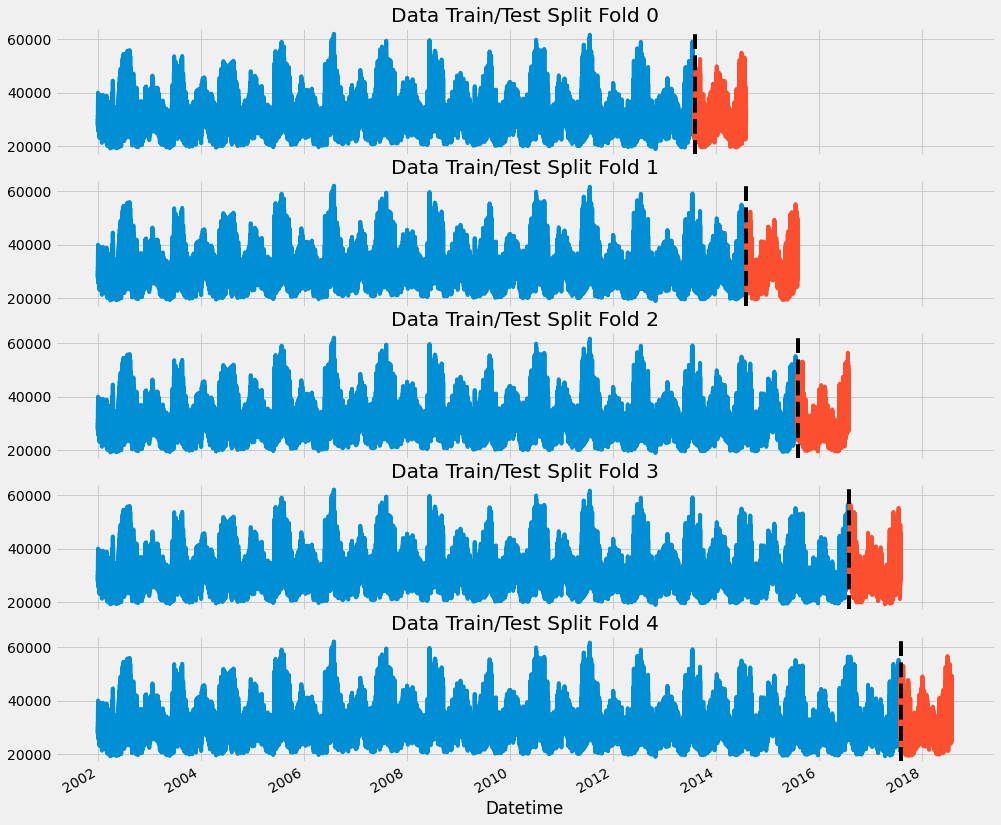

In [89]:
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex = True)
fold = 0

for train_idx, val_idx in tss.split(dfc):
    train_ = dfc.iloc[train_idx]
    test_ = dfc.iloc[val_idx]
    train_['PJME_MW'].plot(ax=axs[fold], label='Training Set', title= f'Data Train/Test Split Fold {fold}')
    test_['PJME_MW'].plot(ax=axs[fold], label = 'Test Set')
    axs[fold].axvline(test_.index.min(), color='black', ls='--')
    fold+=1
plt.show()

# Forcasting Horizon
* This is the length of time into the future for which forecasts are to be prepared. These generally vary from short term forecasting horizons(two months and below) to long term forecasting horizons(over two years)

In [105]:
def create_features(dfc):    #Create time series features based on time series index
    dfc=dfc.copy()   #This ensures that we're editing a copy of the dataframe
    dfc['Hour'] = dfc.index.hour 
    dfc['dayofweek']= dfc.index.dayofweek
    dfc['Quarter']= dfc.index.quarter
    dfc['Month'] = dfc.index.month
    dfc['Year'] = dfc.index.year
    dfc['Dayofyear'] =  dfc.index.dayofyear
    dfc['dayofmonth'] = dfc.index.day
    dfc['weekofyear'] = dfc.index.isocalendar().week
    return dfc
dfc = create_features(dfc)

# Lag Features

## What was the target x days in the past

In [106]:
dfc

,PJME_MW,Hour,dayofweek,Quarter,Month,Year,Dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31


In [107]:
target_map = dfc['PJME_MW'].to_dict()

In [126]:
dfc['lag1'] = (dfc.index - pd.Timedelta('364 days')).map(target_map)
#364 because it is divisible by 7 so we can say 'thos same day last year, on the same day of the wek'.
dfc['lag2'] = (dfc.index - pd.Timedelta('728 days')).map(target_map)
dfc['lag3'] = (dfc.index - pd.Timedelta('1092 days')).map(target_map)
#The number of days shouldnt be longer than the forecasting horizon.

In [128]:
def add_lags(dfc):
    target_map = dfc['PJME_MW'].to_dict()
    dfc['lag1'] = (dfc.index - pd.Timedelta('364 days')).map(target_map)
    dfc['lag2'] = (dfc.index - pd.Timedelta('728 days')).map(target_map)
    dfc['lag3'] = (dfc.index - pd.Timedelta('1092 days')).map(target_map)
    return dfc

In [129]:
dfc = add_lags(dfc)

In [130]:
dfc.head()

,PJME_MW,Hour,dayofweek,Quarter,Month,Year,Dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN


# Training Cross Validation

In [140]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24 )
dfc = dfc.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(dfc):
    train_ = dfc.iloc[train_idx]
    test_ = dfc.iloc[val_idx]
    
    train_ = create_features(train_)
    test_ = create_features(test_)
    
    features_ = ['Hour', 'dayofweek', 'Quarter', 'Month', 'Year', 'Dayofyear', 'lag1', 'lag2', 'lag3']
    target_ = 'PJME_MW'
    
    X_train = train_[features_]
    y_train = train_[target_]
    
    X_test = test_[features_]
    y_test = test_[target_]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators = 1000, 
                           early_stopping_rounds = 50,
                          objective = 'reg:linear',
                          max_depth=3,
                          learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose = 100)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[10:12:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.10915	validation_1-rmse:11906.70125
[200]	validation_0-rmse:5739.78666	validation_1-rmse:5352.86754
[300]	validation_0-rmse:3868.29390	validation_1-rmse:3891.32148
[400]	validation_0-rmse:3428.85875	validation_1-rmse:3753.95996
[456]	validation_0-rmse:3349.18480	validation_1-rmse:3761.64093
[10:12:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.25338	validation_1-rmse:12222.97626
[200]	validation_0-rms

In [141]:
scores

[3753.2775219986684,
 3434.3528874818867,
 3475.9138463312997,
 4093.7260445492084,
 3996.298054855067]

In [142]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3750.7137
Fold scores:[3753.2775219986684, 3434.3528874818867, 3475.9138463312997, 4093.7260445492084, 3996.298054855067]


# Predicting the Future

* Retraining on all data
* To predict the future, we need an empty dataframe for future date ranges
+ Run those dates through our future creation code + lag creation

In [143]:
#First, we'll retrain on all data

dfc = create_features(dfc)
   
features_ = ['Hour', 'dayofweek', 'Quarter', 'Month', 'Year', 'Dayofyear', 'lag1', 'lag2', 'lag3']
target_ = 'PJME_MW'


X_all = dfc[features_]
y_all = dfc[target_]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators = 1000, 
                       early_stopping_rounds = 50,
                      objective = 'reg:linear',
                      max_depth=3,
                      learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose = 100)


[10:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.44700
[200]	validation_0-rmse:5752.69704
[300]	validation_0-rmse:3970.08787
[400]	validation_0-rmse:3569.37848
[500]	validation_0-rmse:3453.91141
[600]	validation_0-rmse:3401.16957
[700]	validation_0-rmse:3364.74781
[800]	validation_0-rmse:3335.24875
[900]	validation_0-rmse:3307.77800
[999]	validation_0-rmse:3283.27077


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [144]:
#Create future dataframe

dfc.index.max() #To check for the last date, so we'll make it the first date for our future dataframe.

Timestamp('2018-08-03 00:00:00')

In [149]:
#Create future dataframe
future = pd.date_range('2018-08-03', '2019-08-01', freq = '1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
dfc['isFuture'] = False
df_and_future = pd.concat([dfc, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [150]:
df_and_future

,PJME_MW,Hour,dayofweek,Quarter,Month,Year,Dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [151]:
future_w_features = df_and_future.query('isFuture').copy()

In [152]:
future_w_features

,PJME_MW,Hour,dayofweek,Quarter,Month,Year,Dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [153]:
#Predict the future

future_w_features['pred'] = reg.predict(future_w_features[features_])

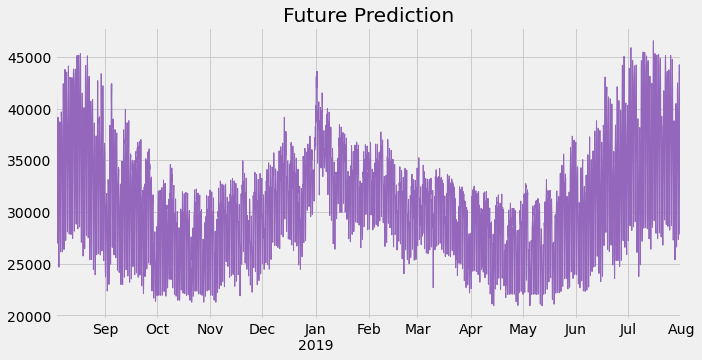

In [155]:
future_w_features['pred'].plot(figsize=(10,5),
                              color=color_pal[4], 
                              ms=1, lw=1, 
                              title= 'Future Prediction')
plt.show()

# Saving the model

In [157]:
reg.save_model('model.json')